
# Introduction #

Welcome to the [**Petals to the Metal**](https://www.kaggle.com/c/tpu-getting-started) competition! In this competition, you’re challenged to build a machine learning model to classify 104 types of flowers based on their images.

In this tutorial notebook, you'll learn how to build an image classifier in Keras and train it on a [Tensor Processing Unit (TPU)](https://www.kaggle.com/docs/tpu). At the end, you'll have a complete project you can build off of with ideas of your own.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Fork This Notebook!</strong><br>
Create your own editable copy of this notebook by clicking on the <strong>Copy and Edit</strong> button in the top right corner.
</blockquote>

# Шаг 1. Импорт #

Начнем с импорта нескольких пакетов Python.

In [1]:
import math, re, os
import numpy as np
import tensorflow as tf

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


# Шаг 2: Стратегия распространения #

TPU имеет восемь различных * ядер *, и каждое из этих ядер действует как собственный ускоритель. (TPU - это что-то вроде восьми графических процессоров на одной машине.) Мы сообщаем TensorFlow, как использовать все эти ядра одновременно с помощью ** стратегии распространения **. Запустите следующую ячейку, чтобы создать стратегию распространения, которую мы позже применим к нашей модели.

In [2]:
#Обнаружение TPU, возврат соответствующей стратегии распределения
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH)

gs://kds-8079b453fa6d362d38dc1a2ceaee58cde7e7606bbcaa0d95626565d2


Мы будем использовать стратегию распространения при создании нашей модели нейронной сети. Затем TensorFlow распределит обучение между восемью ядрами TPU, создав восемь различных * реплик * модели, по одной для каждого ядра.

# Шаг 3. Загрузка данных о соревнованиях #

## Получить путь GCS ##

При использовании с TPU наборы данных должны храниться в [корзине Google Cloud Storage] (https://cloud.google.com/storage/). Вы можете использовать данные из любой общедоступной корзины GCS, указав ее путь так же, как данные из '/ kaggle / input'. Следующее будет извлекать путь GCS для набора данных этого соревнования.

In [4]:
from kaggle_datasets import KaggleDatasets

GCS_DS_PATH = KaggleDatasets().get_gcs_path('tpu-getting-started')
print(GCS_DS_PATH) 

gs://kds-8079b453fa6d362d38dc1a2ceaee58cde7e7606bbcaa0d95626565d2


Таким же образом вы можете использовать данные из любого общедоступного набора данных здесь, на Kaggle. Если вы хотите использовать данные из одного из ваших частных наборов данных, см. [Здесь] (https://www.kaggle.com/docs/tpu#tpu3pt5).
Взаимодействие с другими людьми
## Загрузить данные ##
Взаимодействие с другими людьми
При использовании с TPU наборы данных часто сериализуются в [TFRecords] (https://www.kaggle.com/ryanholbrook/tfrecords-basics). Это удобный формат для распределения данных по каждому из ядер TPU. Мы скрыли ячейку, которая читает TFRecords для нашего набора данных, так как процесс немного длинный. Вы можете вернуться к нему позже, чтобы получить некоторые рекомендации по использованию ваших собственных наборов данных с TPU.

In [5]:

IMAGE_SIZE = [512, 512]
GCS_PATH = GCS_DS_PATH + '/tfrecords-jpeg-512x512'

AUTO = tf.data.experimental.AUTOTUNE

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # преобразовать изображение в число с плавающей запятой в диапазоне [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # явный размер, необходимый для TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string получает байтовую строку
        "class": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # возвращает набор данных пар (изображение, метка)

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
        # class отсутствует, задача этого конкурса - предсказать классы цветов для тестового набора данных.
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # возвращает набор данных изображений

def load_dataset(filenames, labeled=True, ordered=False):
    # Читать из TFRecords. Для оптимальной производительности чтение сразу из нескольких файлов и
     # без учета порядка данных. Порядок не имеет значения, поскольку мы все равно будем перетасовывать данные.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # отключить порядок, увеличить скорость

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # автоматически чередует чтение из нескольких файлов

    dataset = dataset.with_options(ignore_order) # использует данные сразу после их поступления, а не в исходном порядке

    # Распараллеливание преобразования данных
    # При подготовке данных может потребоваться предварительная обработка входных элементов. С этой целью API tf.data предлагает преобразование tf.data.Dataset.map,
    # который применяет пользовательскую функцию к каждому элементу входного набора данных. Поскольку входные элементы не зависят друг от друга,
    # предварительная обработка может быть распараллелена между несколькими ядрами ЦП. Чтобы сделать это возможным, аналогично преобразованиям предварительной выборки и чередования,
    # преобразование карты предоставляет аргумент num_parallel_calls для указания уровня параллелизма.
    # Выбор лучшего значения для аргумента num_parallel_calls зависит от вашего оборудования,
    # характеристики ваших тренировочных данных (например, размер и форма),
    # стоимость вашей функции карты и то, какая другая обработка одновременно происходит на ЦП.
    # Простая эвристика - использовать количество доступных ядер ЦП. Однако, что касается преобразования предварительной выборки и чередования,
    # преобразование карты поддерживает tf.data.experimental.
    # AUTOTUNE, который делегирует решение о том, какой уровень параллелизма использовать среде выполнения tf.data.
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # возвращает набор данных пар (изображение, метка), если метка = True, или пар (изображение, идентификатор), если метка = False
    return dataset

In [6]:
print(len(CLASSES))

104


## Создание конвейеров данных ##

На этом последнем шаге мы будем использовать API tf.data для определения эффективного конвейера данных для каждого из разделов обучения, проверки и тестирования.

In [7]:
# определенно увеличить объем данных
def data_augment(image, label):
    # Благодаря dataset.prefetch (АВТО)
    # в следующей функции (ниже), по сути, это происходит
    # бесплатно на ТПУ. Код конвейера данных выполняется на «CPU»
    # часть TPU, в то время как сам TPU вычисляет градиенты.
    image = tf.image.random_flip_left_right(image)
    # Добавить 6 пикселей отступа
    image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE[0] + 20, IMAGE_SIZE[1] + 20)
    # Случайное кадрирование до исходного размера
    image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)

    dataset = dataset.repeat()# набор обучающих данных должен повторяться в течение нескольких эпох
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    # Предварительная загрузка
     # Предварительная выборка перекрывает предварительную обработку и выполнение модели на этапе обучения.
     # Пока модель выполняет шаг обучения s, входной конвейер считывает данные для шага s + 1.
     # Это сокращает время шага до максимума (в отличие от суммы) тренировки
     # и время, необходимое для извлечения данных.
    dataset = dataset.prefetch(AUTO) # предварительная выборка следующего пакета во время обучения (размер буфера предварительной выборки автонастройки)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    print(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # количество элементов данных записывается в имя .tfrec
     # файлов, т.е. flowers00-230.tfrec = 230 элементов данных
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))


Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


В следующей ячейке будут созданы наборы данных, которые мы будем использовать с Keras во время обучения и вывода. Обратите внимание, как мы масштабируем размер пакетов в соответствии с количеством ядер TPU.

In [8]:
# Определить размер партии. Это будет 16 при выключенном TPU и 128 (= 16 * 8) при включенном TPU.
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

ds_train = get_training_dataset()
ds_valid = get_validation_dataset()
ds_test = get_test_dataset()

print("Training:", ds_train)
print ("Validation:", ds_valid)
print("Test:", ds_test)

16
Training: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Validation: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.int32)>
Test: <PrefetchDataset shapes: ((None, 512, 512, 3), (None,)), types: (tf.float32, tf.string)>


Эти наборы данных являются объектами tf.data.Dataset. Вы можете рассматривать набор данных в TensorFlow как * поток * записей данных. Наборы для обучения и проверки представляют собой потоки пар `(изображение, метка)`.

In [9]:
np.set_printoptions(threshold=15, linewidth=80)

print("Training data shapes:")
for image, label in ds_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Training data label examples: [ 0 19 94 ... 73 29  4]


Набор тестов представляет собой поток пар `(image, idnum)`; idnum - это уникальный идентификатор, присвоенный изображению, который мы будем использовать позже при отправке в виде файла csv.

In [10]:
print("Test data shapes:")
for image, idnum in ds_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U = строка юникода

Test data shapes:
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
(16, 512, 512, 3) (16,)
Test data IDs: ['f20ae4712' '165766e9b' 'ad2e27bb5' ... '8a4293e72' '06ebbb560' 'b364e8688']


In [11]:
for x,y in ds_train.take(3):
    print(y)

tf.Tensor([87 30 80 ...  4 49 46], shape=(16,), dtype=int32)
tf.Tensor([ 71   1   4 ... 103  83  47], shape=(16,), dtype=int32)
tf.Tensor([73 86 67 ... 24 16 61], shape=(16,), dtype=int32)


# Шаг 4. Изучите данные #

Давайте посмотрим на некоторые изображения в наборе данных.

In [13]:

from matplotlib import pyplot as plt

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # двоичная строка в данном случае,
                                      # это строки идентификатора изображения
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # Если меток нет, только идентификаторы изображений, для меток вернуть None (это
     # случай для тестовых данных)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # автоквадрат: при этом будут отброшены данные, которые не помещаются в квадрат.
     # или квадратный прямоугольник
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # размер и интервал
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # магическая формула протестирована для работы с изображениями от 1x1 до 10x10
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #макет
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # настраиваем подзаговоры при первом вызове
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

Вы можете отобразить один пакет изображений из набора данных с помощью другой из наших вспомогательных функций. Следующая ячейка превратит набор данных в итератор пакетов из 20 изображений.

In [14]:
ds_iter = iter(ds_train.unbatch().batch(20))

Используйте функцию Python `next`, чтобы вывести следующий пакет в потоке и отобразить его с помощью вспомогательной функции.

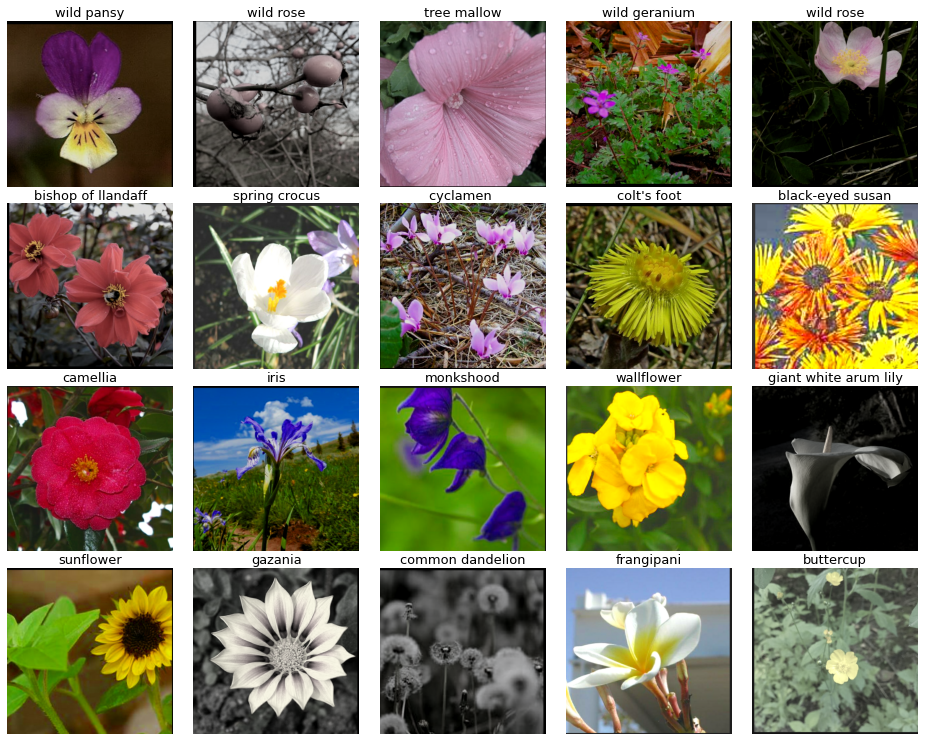

In [17]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

Определив ds_iter и one_batch в отдельных ячейках, вам нужно только повторно запустить ячейку выше, чтобы увидеть новый пакет изображений.

# Шаг 5: Определите модель #

Теперь мы готовы создать нейронную сеть для классификации изображений! Мы будем использовать так называемое ** трансферное обучение **. При трансферном обучении вы повторно используете часть предварительно обученной модели, чтобы начать работу с новым набором данных.

В этом руководстве мы будем использовать модель под названием ** VGG16 **, предварительно обученную на [ImageNet] (http://image-net.org/)). Позже вы можете поэкспериментировать с [другими моделями] (https://www.tensorflow.org/api_docs/python/tf/keras/applications), включенными в Keras. ([Xception] (https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception) было бы неплохим выбором.)

Стратегия распространения, которую мы создали ранее, содержит [диспетчер контекста] (https://docs.python.org/3/reference/compound_stmts.html#with), `strategy.scope`. Этот диспетчер контекста сообщает TensorFlow, как разделить работу по обучению между восемью ядрами TPU. При использовании TensorFlow с TPU важно определить вашу модель в контексте «strategy.scope ()«.

In [15]:
print(*IMAGE_SIZE)

512 512


In [16]:
from keras.layers import Flatten, Dense, BatchNormalization, Activation,Dropout

EPOCHS = 10

with strategy.scope():
    pretrained_model = tf.keras.applications.VGG19(
        weights='imagenet',
        include_top=False ,
        input_shape=[*IMAGE_SIZE, 3]
    )
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        # К базе, предварительно обученной на ImageNet для извлечения функций из изображений ...
        pretrained_model,
        # ... прикрепите новую голову, чтобы действовать как классификатор.
        Flatten(),
        Dense(1024,activation=('relu'),input_dim=512),
        Dropout(0.5),
        Dense(512,activation=('relu')),
        Dropout(0.5),
        Dense(256,activation=('relu')),
        Dense(128,activation=('relu')),
        Dense(len(CLASSES), activation=('softmax'))
    ])


Версии потерь и метрик sparse_categorical подходят для задачи классификации с более чем двумя метками, как эта.The `'sparse_categorical'` versions of the loss and metrics are appropriate for a classification task with more than two labels, like this one.

In [19]:
model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 16, 16, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1

# Шаг 6: Обучение #

## График обучения ##

Мы обучим эту сеть по специальной программе скорости обучения.

Learning rate schedule: 1e-05 to 5e-05 to 1.54e-05


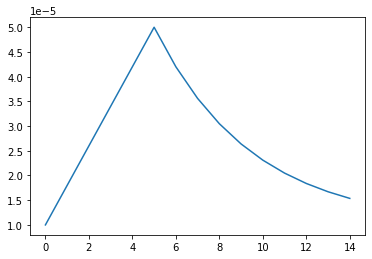

In [20]:

# График скорости обучения для точной настройки #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # линейное увеличение от начала до rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # постоянный max_lr в течение периодов сустейна
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # экспоненциальный спад в сторону min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Подходящая модель ##

Теперь мы готовы обучать модель. После определения нескольких параметров все готово!

In [21]:
# Определить эпохи тренировок
EPOCHS = 15
# Когда настраивать количество шагов на эпоху

# Традиционно количество шагов за эпоху рассчитывается как train_length // batch_size,
# поскольку это будет использовать все точки данных, по одному размеру пакета за раз.
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[lr_callback],
)

Epoch 1/15

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
  9/797 [..............................] - ETA: 5:59:10 - loss: 17.4561 - sparse_categorical_accuracy: 0.0000e+00

KeyboardInterrupt: 

Следующая ячейка показывает, как прогрессировали потери и показатели во время тренировки. К счастью, сходится!

In [22]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

NameError: name 'history' is not defined

# Шаг 7. Оцените прогнозы #

Прежде чем делать окончательные прогнозы по набору тестов, рекомендуется оценить прогнозы вашей модели на наборе проверки. Это может помочь вам диагностировать проблемы в обучении или предложить способы улучшения вашей модели. Мы рассмотрим два распространенных способа проверки: построение ** матрицы путаницы ** и ** визуальной проверки **.

In [23]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # настраиваем подзаговоры при первом вызове
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Матрица неточностей ##
Взаимодействие с другими людьми
[Матрица путаницы] (https://en.wikipedia.org/wiki/Confusion_matrix) показывает фактический класс изображения, сопоставленный с его предсказанным классом. Это один из лучших инструментов для оценки эффективности классификатора.
Взаимодействие с другими людьми
Следующая ячейка выполняет некоторую обработку данных проверки, а затем создает матрицу с функцией confusion_matrix, включенной в [scikit-learn`] (https://scikit-learn.org/stable/index.html).

In [ ]:
cmdataset = get_validation_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)
cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

16


Возможно, вы знакомы с такими показателями, как [F1-score] (https://en.wikipedia.org/wiki/F1_score) или [точность и отзыв] (https://en.wikipedia.org/wiki/Precision_and_recall). Эта ячейка вычислит эти метрики и отобразит их с графиком матрицы неточностей. (Эти метрики определены в модуле Scikit-learn `sklearn.metrics`; мы импортировали их во вспомогательный скрипт для вас.)

In [ ]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)
display_confusion_matrix(cmat, score, precision, recall)

## Визуальная проверка ##

Также может быть полезно взглянуть на некоторые примеры из набора для проверки и увидеть, какой класс предсказал ваша модель. Это может помочь выявить закономерности в изображениях, с которыми у вашей модели проблемы.

Эта ячейка настроит набор проверки для отображения 20 изображений за раз - вы можете изменить это, чтобы отображать больше или меньше, если хотите.

In [ ]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

А вот и набор цветов с их предсказанными видами. Снова запустите ячейку, чтобы увидеть другой набор.

In [ ]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

# Шаг 8: Тестовые прогнозы #

Когда вас все устраивает, вы готовы делать прогнозы на тестовой выборке.

In [ ]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

Мы сгенерируем файл `submission.csv`. Этот файл вы отправите, чтобы получить свой результат в таблице лидеров.

In [ ]:
print('Generating submission.csv file...')

# Получить идентификаторы изображений из тестового набора и преобразовать в Unicode
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

#Напишите файл представления
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, predictions]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)

# Посмотрите на первые несколько предсказаний
!head submission.csv

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/161321) to chat with other Learners.*

